Rate: 0.1, Epochs: 50
Rate: 0.1, Epochs: 200
Rate: 0.1, Epochs: 500
Rate: 0.01, Epochs: 50
Rate: 0.01, Epochs: 200
Rate: 0.01, Epochs: 500
Rate: 0.001, Epochs: 50
Rate: 0.001, Epochs: 200
Rate: 0.001, Epochs: 500
Hyperparameters: (0.1 rate, 50 epochs) -- Fold 1 mean_train_loss: 0.0552 -- Fold 1 mean_val_loss: 0.1499
Hyperparameters: (0.1 rate, 50 epochs) -- Fold 2 mean_train_loss: 0.0573 -- Fold 2 mean_val_loss: 0.1338
Hyperparameters: (0.1 rate, 50 epochs) -- Fold 3 mean_train_loss: 0.0594 -- Fold 3 mean_val_loss: 0.1048
Hyperparameters: (0.1 rate, 50 epochs) -- Fold 4 mean_train_loss: 0.0559 -- Fold 4 mean_val_loss: 0.1347
Hyperparameters: (0.1 rate, 50 epochs) -- Fold 5 mean_train_loss: 0.0541 -- Fold 5 mean_val_loss: 0.2004
Hyperparameters: (0.1 rate, 200 epochs) -- Fold 1 mean_train_loss: 0.0297 -- Fold 1 mean_val_loss: 0.1746
Hyperparameters: (0.1 rate, 200 epochs) -- Fold 2 mean_train_loss: 0.0312 -- Fold 2 mean_val_loss: 0.1415
Hyperparameters: (0.1 rate, 200 epochs) -- Fold 3 

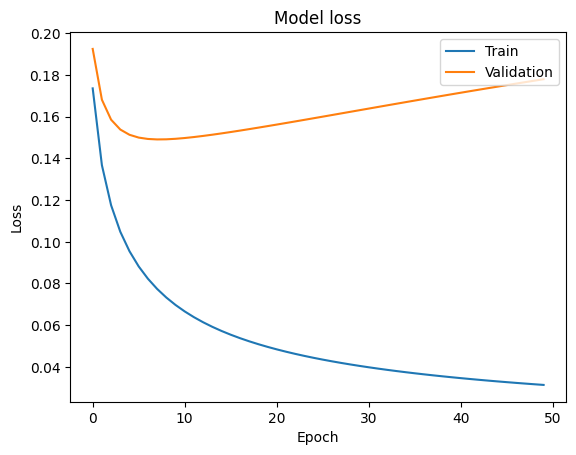

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train = pd.read_csv('./train_midterm.csv')
test = pd.read_csv('./test_midterm.csv')

# y = 1364 column; x = 0 -> 1363 columns; y = 0 -> 4458 rows
x_train = train.drop(['label'], axis=1)
y_train = train['label']

x_test = test.drop(['label'], axis=1)
y_test = test['label']

# turn into arrays for matrix multiplication
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

w = 0 # w_old
rate = [0.1, 0.01, 0.001] # varies
epochs = [50, 200, 500] # varies

training_loss_graph = []
validation_loss_graph = []

"""
print(x_train.shape) # 4459
print(x_train.shape[1]) # 1364
print(y_train.shape) # 1 col
print('label' in train.columns) # True
print(train.columns.get_loc('label')) # 1364
"""

# shuffle the entire training set first
indices = np.random.permutation(len(x_train))
x_shuffled = x_train[indices]
y_shuffled = y_train[indices]

# print(x_shuffled)
# print(y_shuffled)

# for each model, make 5 KFolds, validate 80 20 for each,
# x epochs, mean x epoch losses for 1 fold,
# mean 5 fold losses for 1 model (save this loss)
# kfold.split(x_shuffled) holds the 5 shuffled arrays
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mean_train_loss = []
mean_val_loss = []
temp_train_loss = []
temp_val_loss = []
fold_train_loss = []
fold_val_loss = []
model_train_losses = []
model_val_losses = [] # saves the final val_loss of each model type
current_fold = 1


for i in range(0, len(rate)):
  for j in range(0, len(epochs)):
    print(f"Rate: {rate[i]}, Epochs: {epochs[j]}")

    for train_indices, val_indices in kfold.split(x_train): # does this 5 times
      # split the data between train and validation first
      split_x_train = x_train[train_indices]
      split_y_train = y_train[train_indices]
      split_x_val = x_train[val_indices]
      split_y_val = y_train[val_indices]
      w = 0 # reset weight for each fold

      for k in range(0, epochs[j]):
        # SGD
        for l in range(0, len(split_x_train)):
          prediction = 1 / (1 + np.exp(-split_x_train[l].dot(w))) # 1 / (1 + e^(-wx))
          # loss = # -1 / (number of prediction (aka mean)) * (y * ln(prediction) + (1 - y) * ln(1 - prediction))
          derivative = (prediction - split_y_train[l]) * split_x_train[l] # (prediction - y) * x

          w = w - rate[i]*derivative # w_new

        # after epoch, calculate the loss then add to temp lists
        prediction_train = np.clip((1 / (1 + np.exp(-split_x_train.dot(w)))), 1e-15, 1 - (1e-15)) # epsilon prediction
        prediction_val = np.clip((1 / (1 + np.exp(-split_x_val.dot(w)))), 1e-15, 1 - (1e-15))

        training_loss = np.mean(-split_y_train * np.log(prediction_train) - (1 - split_y_train) * np.log(1 - prediction_train))
        validation_loss = np.mean(-split_y_val * np.log(prediction_val) - (1 - split_y_val) * np.log(1 - prediction_val))
        # training_loss = # -1 / (number of prediction (aka mean)) * (y * ln(prediction) + (1 - y) * ln(1 - prediction))
        # validation_loss = # -1 / (number of prediction (aka mean)) * (y * ln(prediction) + (1 - y) * ln(1 - prediction))

        temp_train_loss.append(training_loss) # should have epochs[j] train losses
        temp_val_loss.append(validation_loss) # epochs[j] val losses

      # after fold, calculate mean of all epochs[j] train and val losses for 1 fold
      fold_training_loss = np.mean(temp_train_loss)
      fold_validation_loss = np.mean(temp_val_loss)

      mean_train_loss.append(fold_training_loss)
      mean_val_loss.append(fold_validation_loss)

      fold_train_loss.append(fold_training_loss)
      fold_val_loss.append(fold_validation_loss)

      # sanity checks - prints 50 epochs
      #print(f"50 epoch train losses: {temp_train_loss}")
      #print(f"50 epoch validation losses: {temp_val_loss}")

      temp_train_loss.clear()
      temp_val_loss.clear()

    # after all 5 folds, calculate train and val losses of entire model
    model_train_losses.append(np.mean(mean_train_loss))
    model_val_losses.append(np.mean(mean_val_loss))

    # sanity checks - prints 5 folds
    #print(f"5 fold train loss means: {mean_train_loss}")
    #print(f"5 fold val loss means: {mean_val_loss}")

    mean_train_loss.clear()
    mean_val_loss.clear()

    # sanity checks - prints 1 model, should increase for every model
    #print(f"1 model final train loss: {model_train_losses}")
    #print(f"1 model final val loss {model_val_losses}")


# should have 45 numbers, 45, 9
#print(fold_train_loss)
#print(fold_val_loss)
#print(model_val_losses)

# print fold train val losses, choose best model, train, validate, test, plot
for i in range (0, 45):
  if (i == 0): # model 1
    rate, epochs = 0.1, 50
  if (i == 5): # model 2
    rate, epochs = 0.1, 200
  if (i == 10): # model 3
    rate, epochs = 0.1, 500
  if (i == 15): # model 4
    rate, epochs = 0.01, 50
  if (i == 20): # model 5
    rate, epochs = 0.01, 200
  if (i == 25): # model 6
    rate, epochs = 0.01, 500
  if (i == 30): # model 7
    rate, epochs = 0.001, 50
  if (i == 35): # model 8
    rate, epochs = 0.001, 200
  if (i == 40): # model 9
    rate, epochs = 0.001, 500
  print(f"Hyperparameters: ({rate} rate, {epochs} epochs) -- Fold {current_fold} mean_train_loss: {fold_train_loss[i]:.4f} -- Fold {current_fold} mean_val_loss: {fold_val_loss[i]:.4f}")
  current_fold += 1
  if (current_fold > 5):
    current_fold = 1

if (model_val_losses.index(min(model_val_losses)) == 0):
  rate, epochs = 0.1, 50
elif (model_val_losses.index(min(model_val_losses)) == 1):
  rate, epochs = 0.1, 200
elif (model_val_losses.index(min(model_val_losses)) == 2):
  rate, epochs = 0.1, 500
elif (model_val_losses.index(min(model_val_losses)) == 3):
  rate, epochs = 0.01, 50
elif (model_val_losses.index(min(model_val_losses)) == 4):
  rate, epochs = 0.01, 200
elif (model_val_losses.index(min(model_val_losses)) == 5):
  rate, epochs = 0.01, 500
elif (model_val_losses.index(min(model_val_losses)) == 6):
  rate, epochs = 0.001, 50
elif (model_val_losses.index(min(model_val_losses)) == 7):
  rate, epochs = 0.001, 200
elif (model_val_losses.index(min(model_val_losses)) == 8):
  rate, epochs = 0.001, 500
print(f"Best Hyperparameters: ({rate} rate, {epochs} epochs)")
w = 0 # reset the weights


# train, val, and test best hyperparameters on shuffled data
for i in range (0, epochs):
  # split the data between train and validation first
  split_x_train, split_x_val = train_test_split(x_train, test_size=0.1, random_state=42)
  split_y_train, split_y_val = train_test_split(y_train, test_size=0.1, random_state=42)

  for j in range(0, len(split_x_train)):
    prediction = 1 / (1 + np.exp(-split_x_train[j].dot(w))) # 1 / (1 + e^(-wx))
    # loss = # -1 / (number of prediction (aka mean)) * (y * ln(prediction) + (1 - y) * ln(1 - prediction))
    derivative = (prediction - split_y_train[j]) * split_x_train[j] # (prediction - y) * x

    w = w - rate*derivative # w_new

  # after epoch, calculate the loss then add to graph lists
  prediction_train = np.clip((1 / (1 + np.exp(-split_x_train.dot(w)))), 1e-15, 1 - (1e-15)) # epsilon prediction
  prediction_val = np.clip((1 / (1 + np.exp(-split_x_val.dot(w)))), 1e-15, 1 - (1e-15))

  training_loss = np.mean(-split_y_train * np.log(prediction_train) - (1 - split_y_train) * np.log(1 - prediction_train))
  validation_loss = np.mean(-split_y_val * np.log(prediction_val) - (1 - split_y_val) * np.log(1 - prediction_val))

  training_loss_graph.append(training_loss)
  validation_loss_graph.append(validation_loss)

  if (i % 10 == 0):
    print(f"Epoch {i}: Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

prediction_test = np.clip((1 / (1 + np.exp(-x_test.dot(w)))), 1e-15, 1 - (1e-15))
test_loss = np.mean(-y_test * np.log(prediction_test) - (1 - y_test) * np.log(1 - prediction_test))

predicted_class = (prediction_test >= 0.5).astype(int)
#print(predicted_class)
accuracy = accuracy_score(y_test, predicted_class)
f1 = f1_score(y_test, predicted_class)

print(f"Final Test Loss: {test_loss}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")


# Plot training & validation loss values
#plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_loss_graph, label='Training Loss')
plt.plot(range(epochs), validation_loss_graph, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()




